In [1]:
from model.my_model import MyModel
from data_preparation.utils import DataPipeline, BatchPipeline

In [2]:
train_file_name = 'train.csv'
test_file_name = 'test.csv'
sample_submission_file_name = 'sample_submission.csv'

In [3]:
data_pipeline = DataPipeline(train_file_name, test_file_name, sample_submission_file_name)

2022-01-19 20:15:42.232648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 20:15:42.268809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 20:15:42.269029: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 20:15:42.270165: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Getting the file: /home/sersery/Desktop/TUM Informatik/WS2122/Applied Deep Learning for NLP/KAGGLE_NLP_with_disaster_tweets/data/train.csv
-----------------------------------------------------------------------------------------
Dataset 
Size: 7613
Dataset examples:
Input: [ 582 1716    1    1    1  662   99  145   87    1  662    1    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
Target: [0. 1.]
Input: [ 209  813  539    8 3344    2  209    5   13 2051    1  743    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0  

In [11]:
# Inspect tweet lengths

<AxesSubplot:ylabel='Frequency'>

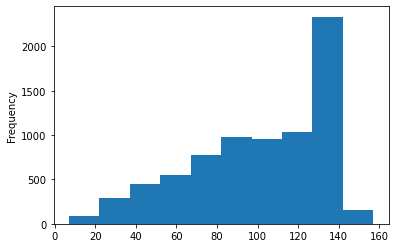

In [13]:
tweet_lengths = data_pipeline.dataframe["text"].map(lambda tweet: len(tweet))
tweet_lengths.plot(kind='hist')

<AxesSubplot:>

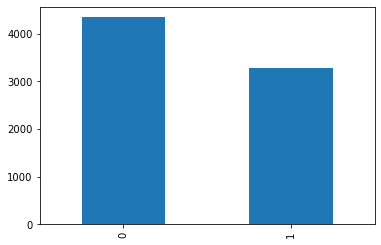

In [4]:
data_pipeline.dataframe["target"].value_counts().plot(kind='bar')

# It can be easily seen that the classes are not distributed evenly.

In [5]:
isTrueCount = data_pipeline.dataframe["target"].where(data_pipeline.dataframe["target"] == 1).count()
isFalseCount = data_pipeline.dataframe["target"].where(data_pipeline.dataframe["target"] == 0).count()
print(f"True instances: {isTrueCount} | {100 * isTrueCount / (isTrueCount + isFalseCount)}% of data")
print(f"False instances: {isFalseCount} | {100 * isFalseCount / (isTrueCount + isFalseCount)}% of data")

True instances: 3271 | 42.965979246026535% of data
False instances: 4342 | 57.034020753973465% of data


# However, the difference is not that big. Just in case, we include balancing of class weights in the hyperparameters.

In [6]:
from tensorboard.plugins.hparams import api as hp
import tensorflow as tf

print(f"Vocabulary size: {data_pipeline.vocabulary_size}")
parameters = {
    "vocabulary_size": data_pipeline.vocabulary_size,
    "embedding_dim": 64,
    "n_labels": 2,
    "epochs": 3,
}

hyperparameters = {"learning_rate": hp.HParam("learning_rate", hp.RealInterval(1e-3, 1e-1)),
                   "hidden_unit": hp.HParam("hidden_unit", hp.Discrete([8, 16, 32, 64, 128])),
                   "batch_size": hp.HParam("batch_size", hp.Discrete([16, 32, 64])),
                   "optimizer": hp.HParam("optimizer", hp.Discrete(["adam", "adamw", "sgd"])),
                   "class_weights": hp.HParam("class_weights", hp.Discrete(["none", "balanced"]))}

Vocabulary size: 5001


In [7]:
from sklearn.utils import class_weight
targets = data_pipeline.dataframe["target"]
balanced_class_weights = dict(enumerate(class_weight.compute_class_weight("balanced",
                                                                          classes=targets.unique().tolist(),
                                                                          y=targets.tolist())))

In [8]:
import os, shutil

log_directory = "./logs/hyperparameter_tuning/"
try:
    shutil.rmtree(log_directory) # clearing logging directory
except NotADirectoryError:
    pass

if not os.path.exists(log_directory):
    os.makedirs(log_directory)


with tf.summary.create_file_writer(log_directory).as_default():
    hp.hparams_config(
        hparams=hyperparameters.values(),
        metrics=[hp.Metric("accuracy", display_name="Accuracy"),
                 hp.Metric("precision", display_name="Precision"),
                 hp.Metric("recall", display_name="Recall"),
                 hp.Metric("f1", display_name="F1 Score")])

In [10]:
batch_size = 32
parameters["epochs"] = 10

hparams = {
    hyperparameters["optimizer"]: "adamw",
    hyperparameters["hidden_unit"]: 16,
    hyperparameters["batch_size"]: batch_size,
    hyperparameters["learning_rate"]: 0.1,
    hyperparameters["class_weights"]: "balanced"
}

my_model = MyModel(batch_pipeline=BatchPipeline(data_pipeline.dataset, batch_size),
                   parameters=parameters,
                   hyperparameters=hyperparameters,
                   hparams=hparams,
                   class_weights=balanced_class_weights)

accuracy, precision, recall, f1 = my_model.fit_and_evaluate(log_directory=log_directory)
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-Score: {f1}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          320064    
                                                                 
 masking_1 (Masking)         (None, None, 64)          0         
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 321,138
Trainable params: 321,138
Non-trainable params: 0
________________________________________________

In [9]:
# look for the best hyperparameters
for optimizer in hyperparameters["optimizer"].domain.values:
    for hidden_unit in hyperparameters["hidden_unit"].domain.values:
        for batch_size in hyperparameters["batch_size"].domain.values:
            for learning_rate in (hyperparameters["learning_rate"].domain.min_value,
                                  hyperparameters["learning_rate"].domain.max_value):
                for class_weights in hyperparameters["class_weights"].domain.values:
                    hparams = {
                        hyperparameters["optimizer"]: optimizer,
                        hyperparameters["hidden_unit"]: hidden_unit,
                        hyperparameters["batch_size"]: batch_size,
                        hyperparameters["learning_rate"]: learning_rate,
                        hyperparameters["class_weights"]: class_weights
                    }
                    my_model = MyModel(batch_pipeline=BatchPipeline(data_pipeline.dataset, batch_size),
                                       parameters=parameters,
                                       hyperparameters=hyperparameters,
                                       hparams=hparams,
                                       class_weights=balanced_class_weights)

                    with tf.summary.create_file_writer(f'{log_directory}{my_model.run_name}').as_default():
                        hp.hparams(hparams)
                        accuracy, precision, recall, f1 = my_model.fit_and_evaluate(log_directory=log_directory)
                        tf.summary.scalar("accuracy", accuracy, step=1)
                        tf.summary.scalar("precision", precision, step=1)
                        tf.summary.scalar("recall", recall, step=1)
                        tf.summary.scalar("f1", f1, step=1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          160032    
                                                                 
 masking (Masking)           (None, None, 32)          0         
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                                 
Total params: 160,314
Trainable params: 160,314
Non-trainable params: 0
__________________________________________________

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 3s 16ms/step - loss: 0.6861 - accuracy: 0.5725 - val_loss: 0.6814 - val_accuracy: 0.5696
Epoch 2/3
95/95 [==============================] - 0s 4ms/step - loss: 0.6790 - accuracy: 0.5725 - val_loss: 0.6771 - val_accuracy: 0.5696
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.6669 - accuracy: 0.5582
run=0__lr=0.001__hidden_unit=8__batch_size=64__optimizer=adam__class_weights=none completed.
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_10 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_10  (None, 32)               0         
  (GlobalAveragePooling1D)                              

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 3s 17ms/step - loss: 0.5487 - accuracy: 0.7021 - val_loss: 0.4365 - val_accuracy: 0.7940
Epoch 2/3
95/95 [==============================] - 0s 4ms/step - loss: 0.3622 - accuracy: 0.8414 - val_loss: 0.3524 - val_accuracy: 0.8338
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.3846 - accuracy: 0.8679
run=0__lr=0.1__hidden_unit=8__batch_size=64__optimizer=adam__class_weights=balanced completed.
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_11 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_11  (None, 32)               0         
  (GlobalAveragePooling1D)                            

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 3s 18ms/step - loss: 0.6845 - accuracy: 0.5676 - val_loss: 0.6771 - val_accuracy: 0.5824
Epoch 2/3
95/95 [==============================] - 0s 4ms/step - loss: 0.6777 - accuracy: 0.5676 - val_loss: 0.6669 - val_accuracy: 0.5824
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.6179 - accuracy: 0.6932
run=0__lr=0.001__hidden_unit=16__batch_size=64__optimizer=adam__class_weights=none completed.
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_22 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_22  (None, 32)               0         
  (GlobalAveragePooling1D)                             

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 21ms/step - loss: 0.6846 - accuracy: 0.5679 - val_loss: 0.6821 - val_accuracy: 0.5653
Epoch 2/3
95/95 [==============================] - 1s 5ms/step - loss: 0.6775 - accuracy: 0.5704 - val_loss: 0.6730 - val_accuracy: 0.5653
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.6238 - accuracy: 0.6847
run=0__lr=0.001__hidden_unit=32__batch_size=64__optimizer=adam__class_weights=none completed.
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_34 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_34  (None, 32)               0         
  (GlobalAveragePooling1D)                             

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 20ms/step - loss: 0.6830 - accuracy: 0.5722 - val_loss: 0.6796 - val_accuracy: 0.5724
Epoch 2/3
95/95 [==============================] - 0s 5ms/step - loss: 0.6757 - accuracy: 0.5722 - val_loss: 0.6662 - val_accuracy: 0.5724
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.5502 - accuracy: 0.8111
run=0__lr=0.001__hidden_unit=64__batch_size=64__optimizer=adam__class_weights=none completed.
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_46 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_46 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_46  (None, 32)               0         
  (GlobalAveragePooling1D)                             

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 6s 9ms/step - loss: 0.6856 - accuracy: 0.5543 - val_loss: 0.6785 - val_accuracy: 0.5745
Epoch 2/3
380/380 [==============================] - 2s 4ms/step - loss: 0.6781 - accuracy: 0.5669 - val_loss: 0.6729 - val_accuracy: 0.5745
Epoch 3/3
47/47 [==============================] - 2s 2ms/step - loss: 0.6737 - accuracy: 0.5572
run=0__lr=0.001__hidden_unit=8__batch_size=16__optimizer=adamw__class_weights=none completed.
Model: "sequential_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_62 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_62 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_62  (None, 32)               0         
  (GlobalAveragePooling1D)                          

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 6s 9ms/step - loss: 0.5795 - accuracy: 0.6845 - val_loss: 0.4170 - val_accuracy: 0.8112
Epoch 2/3
380/380 [==============================] - 2s 4ms/step - loss: 0.3898 - accuracy: 0.8253 - val_loss: 0.3718 - val_accuracy: 0.8497
Epoch 3/3
47/47 [==============================] - 2s 4ms/step - loss: 0.3374 - accuracy: 0.8604
run=0__lr=0.1__hidden_unit=8__batch_size=16__optimizer=adamw__class_weights=balanced completed.
Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_63 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_63 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_63  (None, 32)               0         
  (GlobalAveragePooling1D)                        

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 5s 13ms/step - loss: 0.6818 - accuracy: 0.5740 - val_loss: 0.6734 - val_accuracy: 0.5897
Epoch 2/3
190/190 [==============================] - 1s 5ms/step - loss: 0.6769 - accuracy: 0.5740 - val_loss: 0.6688 - val_accuracy: 0.5897
Epoch 3/3
23/23 [==============================] - 2s 2ms/step - loss: 0.6795 - accuracy: 0.5489
run=0__lr=0.001__hidden_unit=8__batch_size=32__optimizer=adamw__class_weights=none completed.
Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_66 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_66 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_66  (None, 32)               0         
  (GlobalAveragePooling1D)                         

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 5s 13ms/step - loss: 0.5614 - accuracy: 0.6969 - val_loss: 0.4855 - val_accuracy: 0.7582
Epoch 2/3
190/190 [==============================] - 1s 5ms/step - loss: 0.3778 - accuracy: 0.8342 - val_loss: 0.3472 - val_accuracy: 0.8505
Epoch 3/3
23/23 [==============================] - 2s 2ms/step - loss: 0.3292 - accuracy: 0.8818
run=0__lr=0.1__hidden_unit=8__batch_size=32__optimizer=adamw__class_weights=balanced completed.
Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_67 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_67 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_67  (None, 32)               0         
  (GlobalAveragePooling1D)                       

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 22ms/step - loss: 0.6864 - accuracy: 0.5729 - val_loss: 0.6811 - val_accuracy: 0.5753
Epoch 2/3
95/95 [==============================] - 1s 5ms/step - loss: 0.6809 - accuracy: 0.5729 - val_loss: 0.6798 - val_accuracy: 0.5753
Epoch 3/3
11/11 [==============================] - 2s 2ms/step - loss: 0.6762 - accuracy: 0.5852
run=0__lr=0.001__hidden_unit=8__batch_size=64__optimizer=adamw__class_weights=none completed.
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_70 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_70 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_70  (None, 32)               0         
  (GlobalAveragePooling1D)                             

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 5s 23ms/step - loss: 0.5974 - accuracy: 0.6706 - val_loss: 0.3899 - val_accuracy: 0.8409
Epoch 2/3
95/95 [==============================] - 1s 6ms/step - loss: 0.3966 - accuracy: 0.8206 - val_loss: 0.3193 - val_accuracy: 0.8778
Epoch 3/3
11/11 [==============================] - 2s 2ms/step - loss: 0.2884 - accuracy: 0.8963
run=0__lr=0.1__hidden_unit=8__batch_size=64__optimizer=adamw__class_weights=balanced completed.
Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_71 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_71 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_71  (None, 32)               0         
  (GlobalAveragePooling1D)                           

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 6s 9ms/step - loss: 0.6857 - accuracy: 0.5589 - val_loss: 0.6804 - val_accuracy: 0.5625
Epoch 2/3
380/380 [==============================] - 2s 4ms/step - loss: 0.6725 - accuracy: 0.5686 - val_loss: 0.6603 - val_accuracy: 0.5665
Epoch 3/3
47/47 [==============================] - 2s 2ms/step - loss: 0.6355 - accuracy: 0.6396
run=0__lr=0.001__hidden_unit=16__batch_size=16__optimizer=adamw__class_weights=none completed.
Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_74 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_74 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_74  (None, 32)               0         
  (GlobalAveragePooling1D)                         

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 5s 14ms/step - loss: 0.6845 - accuracy: 0.5702 - val_loss: 0.6772 - val_accuracy: 0.5802
Epoch 2/3
190/190 [==============================] - 1s 5ms/step - loss: 0.6789 - accuracy: 0.5702 - val_loss: 0.6735 - val_accuracy: 0.5802
Epoch 3/3
23/23 [==============================] - 2s 2ms/step - loss: 0.6757 - accuracy: 0.5652
run=0__lr=0.001__hidden_unit=16__batch_size=32__optimizer=adamw__class_weights=none completed.
Model: "sequential_78"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_78 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_78 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_78  (None, 32)               0         
  (GlobalAveragePooling1D)                        

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 5s 13ms/step - loss: 0.5694 - accuracy: 0.6933 - val_loss: 0.3825 - val_accuracy: 0.8438
Epoch 2/3
190/190 [==============================] - 1s 5ms/step - loss: 0.3797 - accuracy: 0.8327 - val_loss: 0.3486 - val_accuracy: 0.8573
Epoch 3/3
23/23 [==============================] - 2s 2ms/step - loss: 0.2674 - accuracy: 0.9049
run=0__lr=0.1__hidden_unit=16__batch_size=32__optimizer=adamw__class_weights=balanced completed.
Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_79 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_79 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_79  (None, 32)               0         
  (GlobalAveragePooling1D)                      

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 21ms/step - loss: 0.6869 - accuracy: 0.5720 - val_loss: 0.6847 - val_accuracy: 0.5611
Epoch 2/3
95/95 [==============================] - 0s 5ms/step - loss: 0.6812 - accuracy: 0.5720 - val_loss: 0.6840 - val_accuracy: 0.5611
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.6825 - accuracy: 0.5639
run=0__lr=0.001__hidden_unit=16__batch_size=64__optimizer=adamw__class_weights=none completed.
Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_82 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_82 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_82  (None, 32)               0         
  (GlobalAveragePooling1D)                            

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 20ms/step - loss: 0.6095 - accuracy: 0.6418 - val_loss: 0.4398 - val_accuracy: 0.7955
Epoch 2/3
95/95 [==============================] - 0s 5ms/step - loss: 0.4097 - accuracy: 0.8140 - val_loss: 0.3720 - val_accuracy: 0.8551
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.2935 - accuracy: 0.8892
run=0__lr=0.1__hidden_unit=16__batch_size=64__optimizer=adamw__class_weights=balanced completed.
Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_83 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_83 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_83  (None, 32)               0         
  (GlobalAveragePooling1D)                          

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 5s 8ms/step - loss: 0.6828 - accuracy: 0.5729 - val_loss: 0.6691 - val_accuracy: 0.5918
Epoch 2/3
380/380 [==============================] - 1s 4ms/step - loss: 0.6543 - accuracy: 0.6100 - val_loss: 0.6153 - val_accuracy: 0.7088
Epoch 3/3
47/47 [==============================] - 1s 2ms/step - loss: 0.5721 - accuracy: 0.7739
run=0__lr=0.001__hidden_unit=32__batch_size=16__optimizer=adamw__class_weights=none completed.
Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_86 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_86 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_86  (None, 32)               0         
  (GlobalAveragePooling1D)                         

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 4s 11ms/step - loss: 0.6848 - accuracy: 0.5553 - val_loss: 0.6759 - val_accuracy: 0.5870
Epoch 2/3
190/190 [==============================] - 1s 4ms/step - loss: 0.6772 - accuracy: 0.5735 - val_loss: 0.6698 - val_accuracy: 0.5870
Epoch 3/3
23/23 [==============================] - 2s 2ms/step - loss: 0.6714 - accuracy: 0.5679
run=0__lr=0.001__hidden_unit=32__batch_size=32__optimizer=adamw__class_weights=none completed.
Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_90 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_90 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_90  (None, 32)               0         
  (GlobalAveragePooling1D)                        

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 4s 12ms/step - loss: 0.5743 - accuracy: 0.6916 - val_loss: 0.3807 - val_accuracy: 0.8356
Epoch 2/3
190/190 [==============================] - 1s 4ms/step - loss: 0.3717 - accuracy: 0.8372 - val_loss: 0.3369 - val_accuracy: 0.8614
Epoch 3/3
23/23 [==============================] - 1s 2ms/step - loss: 0.3121 - accuracy: 0.8818
run=0__lr=0.1__hidden_unit=32__batch_size=32__optimizer=adamw__class_weights=balanced completed.
Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_91 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_91 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_91  (None, 32)               0         
  (GlobalAveragePooling1D)                      

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 22ms/step - loss: 0.6884 - accuracy: 0.5370 - val_loss: 0.6889 - val_accuracy: 0.5455
Epoch 2/3
95/95 [==============================] - 1s 5ms/step - loss: 0.6826 - accuracy: 0.5678 - val_loss: 0.6881 - val_accuracy: 0.5455
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.6834 - accuracy: 0.5611
run=0__lr=0.001__hidden_unit=32__batch_size=64__optimizer=adamw__class_weights=none completed.
Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_94 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_94 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_94  (None, 32)               0         
  (GlobalAveragePooling1D)                            

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 20ms/step - loss: 0.5737 - accuracy: 0.6827 - val_loss: 0.3564 - val_accuracy: 0.8665
Epoch 2/3
95/95 [==============================] - 1s 5ms/step - loss: 0.3808 - accuracy: 0.8276 - val_loss: 0.3061 - val_accuracy: 0.8807
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.3471 - accuracy: 0.8636
run=0__lr=0.1__hidden_unit=32__batch_size=64__optimizer=adamw__class_weights=balanced completed.
Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_95 (Embedding)    (None, None, 32)          160032    
                                                                 
 masking_95 (Masking)        (None, None, 32)          0         
                                                                 
 global_average_pooling1d_95  (None, 32)               0         
  (GlobalAveragePooling1D)                          

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 4s 12ms/step - loss: 0.6846 - accuracy: 0.5653 - val_loss: 0.6760 - val_accuracy: 0.5870
Epoch 2/3
190/190 [==============================] - 1s 5ms/step - loss: 0.6781 - accuracy: 0.5683 - val_loss: 0.6682 - val_accuracy: 0.5870
Epoch 3/3
23/23 [==============================] - 2s 2ms/step - loss: 0.6717 - accuracy: 0.5557
run=0__lr=0.001__hidden_unit=64__batch_size=32__optimizer=adamw__class_weights=none completed.
Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_102 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_102 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_10  (None, 32)               0         
 2 (GlobalAveragePooling1D)                      

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 5s 12ms/step - loss: 0.5744 - accuracy: 0.6969 - val_loss: 0.3722 - val_accuracy: 0.8370
Epoch 2/3
190/190 [==============================] - 1s 4ms/step - loss: 0.3800 - accuracy: 0.8357 - val_loss: 0.3203 - val_accuracy: 0.8682
Epoch 3/3
23/23 [==============================] - 2s 2ms/step - loss: 0.3117 - accuracy: 0.8764
run=0__lr=0.1__hidden_unit=64__batch_size=32__optimizer=adamw__class_weights=balanced completed.
Model: "sequential_103"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_103 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_103 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_10  (None, 32)               0         
 3 (GlobalAveragePooling1D)                    

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 5s 23ms/step - loss: 0.6856 - accuracy: 0.5699 - val_loss: 0.6785 - val_accuracy: 0.5824
Epoch 2/3
95/95 [==============================] - 1s 6ms/step - loss: 0.6815 - accuracy: 0.5699 - val_loss: 0.6767 - val_accuracy: 0.5824
Epoch 3/3
11/11 [==============================] - 2s 2ms/step - loss: 0.6778 - accuracy: 0.5753
run=0__lr=0.001__hidden_unit=64__batch_size=64__optimizer=adamw__class_weights=none completed.
Model: "sequential_106"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_106 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_106 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_10  (None, 32)               0         
 6 (GlobalAveragePooling1D)                          

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 5s 23ms/step - loss: 0.6014 - accuracy: 0.6794 - val_loss: 0.3766 - val_accuracy: 0.8565
Epoch 2/3
95/95 [==============================] - 1s 6ms/step - loss: 0.3805 - accuracy: 0.8298 - val_loss: 0.3013 - val_accuracy: 0.8935
Epoch 3/3
11/11 [==============================] - 2s 2ms/step - loss: 0.2847 - accuracy: 0.8849
run=0__lr=0.1__hidden_unit=64__batch_size=64__optimizer=adamw__class_weights=balanced completed.
Model: "sequential_107"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_107 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_107 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_10  (None, 32)               0         
 7 (GlobalAveragePooling1D)                        

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 5s 13ms/step - loss: 0.6849 - accuracy: 0.5625 - val_loss: 0.6851 - val_accuracy: 0.5557
Epoch 2/3
190/190 [==============================] - 1s 5ms/step - loss: 0.6744 - accuracy: 0.5697 - val_loss: 0.6678 - val_accuracy: 0.5557
Epoch 3/3
23/23 [==============================] - 2s 2ms/step - loss: 0.6438 - accuracy: 0.5707
run=0__lr=0.001__hidden_unit=128__batch_size=32__optimizer=adamw__class_weights=none completed.
Model: "sequential_114"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_114 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_114 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_11  (None, 32)               0         
 4 (GlobalAveragePooling1D)                     

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 5s 23ms/step - loss: 0.6874 - accuracy: 0.5477 - val_loss: 0.6852 - val_accuracy: 0.5597
Epoch 2/3
95/95 [==============================] - 1s 6ms/step - loss: 0.6826 - accuracy: 0.5666 - val_loss: 0.6836 - val_accuracy: 0.5597
Epoch 3/3
11/11 [==============================] - 2s 2ms/step - loss: 0.6754 - accuracy: 0.5838
run=0__lr=0.001__hidden_unit=128__batch_size=64__optimizer=adamw__class_weights=none completed.
Model: "sequential_118"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_118 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_118 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_11  (None, 32)               0         
 8 (GlobalAveragePooling1D)                         

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 5s 23ms/step - loss: 0.5847 - accuracy: 0.6697 - val_loss: 0.4360 - val_accuracy: 0.8139
Epoch 2/3
95/95 [==============================] - 1s 6ms/step - loss: 0.3918 - accuracy: 0.8306 - val_loss: 0.3610 - val_accuracy: 0.8310
Epoch 3/3
11/11 [==============================] - 2s 2ms/step - loss: 0.2992 - accuracy: 0.8849
run=0__lr=0.1__hidden_unit=128__batch_size=64__optimizer=adamw__class_weights=balanced completed.
Model: "sequential_119"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_119 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_119 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_11  (None, 32)               0         
 9 (GlobalAveragePooling1D)                       

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 5s 8ms/step - loss: 0.6925 - accuracy: 0.5355 - val_loss: 0.6917 - val_accuracy: 0.5598
Epoch 2/3
380/380 [==============================] - 2s 4ms/step - loss: 0.6909 - accuracy: 0.5714 - val_loss: 0.6908 - val_accuracy: 0.5598
Epoch 3/3
47/47 [==============================] - 2s 2ms/step - loss: 0.6912 - accuracy: 0.5399
run=0__lr=0.001__hidden_unit=8__batch_size=16__optimizer=sgd__class_weights=none completed.
Model: "sequential_122"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_122 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_122 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_12  (None, 32)               0         
 2 (GlobalAveragePooling1D)                          

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 5s 8ms/step - loss: 0.6832 - accuracy: 0.5692 - val_loss: 0.6830 - val_accuracy: 0.5771
Epoch 2/3
380/380 [==============================] - 1s 4ms/step - loss: 0.6813 - accuracy: 0.5702 - val_loss: 0.6830 - val_accuracy: 0.5771
Epoch 3/3
47/47 [==============================] - 2s 2ms/step - loss: 0.6869 - accuracy: 0.5678
run=0__lr=0.1__hidden_unit=8__batch_size=16__optimizer=sgd__class_weights=balanced completed.


/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: "sequential_123"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_123 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_123 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_12  (None, 32)               0         
 3 (GlobalAveragePooling1D)                                      
                                                                 
 dense_246 (Dense)           (None, 8)                 264       
                                                                 
 dense_247 (Dense)           (None, 2)                 18        
                                                                 
Total params: 160,314
Trainable params: 160,314
Non-trainable params: 0
______________________________________________

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 4s 12ms/step - loss: 0.7214 - accuracy: 0.5087 - val_loss: 0.6920 - val_accuracy: 0.5693
Epoch 2/3
190/190 [==============================] - 1s 4ms/step - loss: 0.7180 - accuracy: 0.5729 - val_loss: 0.6909 - val_accuracy: 0.5693
Epoch 3/3
23/23 [==============================] - 2s 2ms/step - loss: 0.6905 - accuracy: 0.5584
run=0__lr=0.001__hidden_unit=8__batch_size=32__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_125"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_125 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_125 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_12  (None, 32)               0         
 5 (GlobalAveragePooling1D)                     

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 4s 12ms/step - loss: 0.6918 - accuracy: 0.5732 - val_loss: 0.6914 - val_accuracy: 0.5761
Epoch 2/3
190/190 [==============================] - 1s 4ms/step - loss: 0.6911 - accuracy: 0.5732 - val_loss: 0.6907 - val_accuracy: 0.5761
Epoch 3/3
23/23 [==============================] - 1s 2ms/step - loss: 0.6921 - accuracy: 0.5312
run=0__lr=0.001__hidden_unit=8__batch_size=32__optimizer=sgd__class_weights=none completed.
Model: "sequential_126"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_126 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_126 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_12  (None, 32)               0         
 6 (GlobalAveragePooling1D)                         

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/3
190/190 [==============================] - 4s 11ms/step - loss: 0.6846 - accuracy: 0.5720 - val_loss: 0.6752 - val_accuracy: 0.6019
Epoch 2/3
190/190 [==============================] - 1s 4ms/step - loss: 0.6806 - accuracy: 0.5720 - val_loss: 0.6752 - val_accuracy: 0.6019
Epoch 3/3
23/23 [==============================] - 1s 2ms/step - loss: 0.7138 - accuracy: 0.5353
run=0__lr=0.1__hidden_unit=8__batch_size=32__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_127"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_127 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_127 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_12  (None, 32)               0         
 7 (GlobalAveragePooling1D)             

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 4s 11ms/step - loss: 0.6845 - accuracy: 0.5681 - val_loss: 0.6768 - val_accuracy: 0.5910
Epoch 2/3
190/190 [==============================] - 1s 3ms/step - loss: 0.6838 - accuracy: 0.5694 - val_loss: 0.6768 - val_accuracy: 0.5910
Epoch 3/3
23/23 [==============================] - 1s 2ms/step - loss: 0.6865 - accuracy: 0.5598
run=0__lr=0.1__hidden_unit=8__batch_size=32__optimizer=sgd__class_weights=none completed.
Model: "sequential_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_128 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_128 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_12  (None, 32)               0         
 8 (GlobalAveragePooling1D)                           

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 20ms/step - loss: 0.7178 - accuracy: 0.5650 - val_loss: 0.6916 - val_accuracy: 0.5767
Epoch 2/3
95/95 [==============================] - 0s 4ms/step - loss: 0.7168 - accuracy: 0.5650 - val_loss: 0.6911 - val_accuracy: 0.5767
Epoch 3/3
11/11 [==============================] - 2s 2ms/step - loss: 0.6909 - accuracy: 0.5682
run=0__lr=0.001__hidden_unit=8__batch_size=64__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_129"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_129 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_129 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_12  (None, 32)               0         
 9 (GlobalAveragePooling1D)                         

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 19ms/step - loss: 0.6931 - accuracy: 0.5054 - val_loss: 0.6924 - val_accuracy: 0.5668
Epoch 2/3
95/95 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5694 - val_loss: 0.6915 - val_accuracy: 0.5668
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.6911 - accuracy: 0.5582
run=0__lr=0.001__hidden_unit=8__batch_size=64__optimizer=sgd__class_weights=none completed.
Model: "sequential_130"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_130 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_130 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_13  (None, 32)               0         
 0 (GlobalAveragePooling1D)                             

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 19ms/step - loss: 0.6862 - accuracy: 0.5699 - val_loss: 0.6953 - val_accuracy: 0.5696
Epoch 2/3
95/95 [==============================] - 0s 4ms/step - loss: 0.6812 - accuracy: 0.5699 - val_loss: 0.6957 - val_accuracy: 0.5696
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.6891 - accuracy: 0.5810
run=0__lr=0.1__hidden_unit=8__batch_size=64__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_131"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_131 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_131 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_13  (None, 32)               0         
 1 (GlobalAveragePooling1D)                           

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 20ms/step - loss: 0.6866 - accuracy: 0.5671 - val_loss: 0.6872 - val_accuracy: 0.5540
Epoch 2/3
95/95 [==============================] - 0s 4ms/step - loss: 0.6843 - accuracy: 0.5671 - val_loss: 0.6873 - val_accuracy: 0.5540
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.6832 - accuracy: 0.5710
run=0__lr=0.1__hidden_unit=8__batch_size=64__optimizer=sgd__class_weights=none completed.
Model: "sequential_132"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_132 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_132 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_13  (None, 32)               0         
 2 (GlobalAveragePooling1D)                               

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 5s 7ms/step - loss: 0.7201 - accuracy: 0.5217 - val_loss: 0.6908 - val_accuracy: 0.5598
Epoch 2/3
380/380 [==============================] - 1s 3ms/step - loss: 0.7123 - accuracy: 0.5730 - val_loss: 0.6888 - val_accuracy: 0.5598
Epoch 3/3
47/47 [==============================] - 2s 2ms/step - loss: 0.6889 - accuracy: 0.5492
run=0__lr=0.001__hidden_unit=16__batch_size=16__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_133"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_133 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_133 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_13  (None, 32)               0         
 3 (GlobalAveragePooling1D)                     

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 5s 7ms/step - loss: 0.6907 - accuracy: 0.5681 - val_loss: 0.6907 - val_accuracy: 0.5505
Epoch 2/3
380/380 [==============================] - 1s 3ms/step - loss: 0.6890 - accuracy: 0.5681 - val_loss: 0.6898 - val_accuracy: 0.5505
Epoch 3/3
47/47 [==============================] - 2s 2ms/step - loss: 0.6885 - accuracy: 0.5585
run=0__lr=0.001__hidden_unit=16__batch_size=16__optimizer=sgd__class_weights=none completed.
Model: "sequential_134"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_134 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_134 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_13  (None, 32)               0         
 4 (GlobalAveragePooling1D)                         

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 5s 8ms/step - loss: 0.6840 - accuracy: 0.5678 - val_loss: 0.6985 - val_accuracy: 0.5625
Epoch 2/3
380/380 [==============================] - 1s 3ms/step - loss: 0.6825 - accuracy: 0.5678 - val_loss: 0.6984 - val_accuracy: 0.5625
Epoch 3/3
47/47 [==============================] - 2s 2ms/step - loss: 0.6932 - accuracy: 0.5718
run=0__lr=0.1__hidden_unit=16__batch_size=16__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_135"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_135 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_135 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_13  (None, 32)               0         
 5 (GlobalAveragePooling1D)                       

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 5s 7ms/step - loss: 0.6833 - accuracy: 0.5724 - val_loss: 0.6720 - val_accuracy: 0.6037
Epoch 2/3
380/380 [==============================] - 1s 3ms/step - loss: 0.6828 - accuracy: 0.5732 - val_loss: 0.6720 - val_accuracy: 0.6037
Epoch 3/3
47/47 [==============================] - 2s 2ms/step - loss: 0.6874 - accuracy: 0.5585
run=0__lr=0.1__hidden_unit=16__batch_size=16__optimizer=sgd__class_weights=none completed.
Model: "sequential_136"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_136 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_136 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_13  (None, 32)               0         
 6 (GlobalAveragePooling1D)                           

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 4s 12ms/step - loss: 0.7209 - accuracy: 0.5202 - val_loss: 0.6908 - val_accuracy: 0.5938
Epoch 2/3
190/190 [==============================] - 1s 4ms/step - loss: 0.7160 - accuracy: 0.5730 - val_loss: 0.6885 - val_accuracy: 0.5938
Epoch 3/3
23/23 [==============================] - 1s 2ms/step - loss: 0.6890 - accuracy: 0.5625
run=0__lr=0.001__hidden_unit=16__batch_size=32__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_137"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_137 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_137 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_13  (None, 32)               0         
 7 (GlobalAveragePooling1D)                    

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 4s 12ms/step - loss: 0.6939 - accuracy: 0.4349 - val_loss: 0.6931 - val_accuracy: 0.4837
Epoch 2/3
190/190 [==============================] - 1s 4ms/step - loss: 0.6925 - accuracy: 0.5679 - val_loss: 0.6918 - val_accuracy: 0.5774
Epoch 3/3
23/23 [==============================] - 2s 2ms/step - loss: 0.6901 - accuracy: 0.5924
run=0__lr=0.001__hidden_unit=16__batch_size=32__optimizer=sgd__class_weights=none completed.
Model: "sequential_138"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_138 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_138 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_13  (None, 32)               0         
 8 (GlobalAveragePooling1D)                        

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 4s 12ms/step - loss: 0.6852 - accuracy: 0.5681 - val_loss: 0.6858 - val_accuracy: 0.5788
Epoch 2/3
190/190 [==============================] - 1s 5ms/step - loss: 0.6814 - accuracy: 0.5701 - val_loss: 0.6858 - val_accuracy: 0.5788
Epoch 3/3
23/23 [==============================] - 2s 2ms/step - loss: 0.6962 - accuracy: 0.5584
run=0__lr=0.1__hidden_unit=16__batch_size=32__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_139"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_139 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_139 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_13  (None, 32)               0         
 9 (GlobalAveragePooling1D)                      

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 4s 12ms/step - loss: 0.6824 - accuracy: 0.5766 - val_loss: 0.6824 - val_accuracy: 0.5734
Epoch 2/3
190/190 [==============================] - 1s 4ms/step - loss: 0.6816 - accuracy: 0.5770 - val_loss: 0.6824 - val_accuracy: 0.5734
Epoch 3/3
23/23 [==============================] - 2s 2ms/step - loss: 0.6769 - accuracy: 0.5897
run=0__lr=0.1__hidden_unit=16__batch_size=32__optimizer=sgd__class_weights=none completed.
Model: "sequential_140"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_140 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_140 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_14  (None, 32)               0         
 0 (GlobalAveragePooling1D)                          

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 21ms/step - loss: 0.7222 - accuracy: 0.4808 - val_loss: 0.6929 - val_accuracy: 0.5781
Epoch 2/3
95/95 [==============================] - 0s 4ms/step - loss: 0.7207 - accuracy: 0.5743 - val_loss: 0.6921 - val_accuracy: 0.5781
Epoch 3/3
11/11 [==============================] - 2s 2ms/step - loss: 0.6916 - accuracy: 0.5696
run=0__lr=0.001__hidden_unit=16__batch_size=64__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_141"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_141 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_141 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_14  (None, 32)               0         
 1 (GlobalAveragePooling1D)                        

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 20ms/step - loss: 0.6927 - accuracy: 0.5719 - val_loss: 0.6922 - val_accuracy: 0.5767
Epoch 2/3
95/95 [==============================] - 1s 6ms/step - loss: 0.6918 - accuracy: 0.5719 - val_loss: 0.6914 - val_accuracy: 0.5767
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.6913 - accuracy: 0.5597
run=0__lr=0.001__hidden_unit=16__batch_size=64__optimizer=sgd__class_weights=none completed.
Model: "sequential_142"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_142 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_142 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_14  (None, 32)               0         
 2 (GlobalAveragePooling1D)                            

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 20ms/step - loss: 0.6879 - accuracy: 0.5666 - val_loss: 0.6882 - val_accuracy: 0.5767
Epoch 2/3
95/95 [==============================] - 0s 4ms/step - loss: 0.6818 - accuracy: 0.5689 - val_loss: 0.6890 - val_accuracy: 0.5767
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.6999 - accuracy: 0.5582
run=0__lr=0.1__hidden_unit=16__batch_size=64__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_143"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_143 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_143 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_14  (None, 32)               0         
 3 (GlobalAveragePooling1D)                          

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 21ms/step - loss: 0.6865 - accuracy: 0.5653 - val_loss: 0.6809 - val_accuracy: 0.5810
Epoch 2/3
95/95 [==============================] - 0s 5ms/step - loss: 0.6842 - accuracy: 0.5673 - val_loss: 0.6803 - val_accuracy: 0.5810
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.6850 - accuracy: 0.5639
run=0__lr=0.1__hidden_unit=16__batch_size=64__optimizer=sgd__class_weights=none completed.
Model: "sequential_144"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_144 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_144 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_14  (None, 32)               0         
 4 (GlobalAveragePooling1D)                              

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 5s 7ms/step - loss: 0.7186 - accuracy: 0.5495 - val_loss: 0.6889 - val_accuracy: 0.5931
Epoch 2/3
380/380 [==============================] - 1s 3ms/step - loss: 0.7112 - accuracy: 0.5720 - val_loss: 0.6848 - val_accuracy: 0.5931
Epoch 3/3
47/47 [==============================] - 2s 2ms/step - loss: 0.6881 - accuracy: 0.5519
run=0__lr=0.001__hidden_unit=32__batch_size=16__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_145"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_145 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_145 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_14  (None, 32)               0         
 5 (GlobalAveragePooling1D)                     

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 5s 7ms/step - loss: 0.6911 - accuracy: 0.5688 - val_loss: 0.6909 - val_accuracy: 0.5519
Epoch 2/3
380/380 [==============================] - 1s 3ms/step - loss: 0.6893 - accuracy: 0.5688 - val_loss: 0.6898 - val_accuracy: 0.5519
Epoch 3/3
47/47 [==============================] - 2s 2ms/step - loss: 0.6880 - accuracy: 0.5625
run=0__lr=0.001__hidden_unit=32__batch_size=16__optimizer=sgd__class_weights=none completed.
Model: "sequential_146"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_146 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_146 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_14  (None, 32)               0         
 6 (GlobalAveragePooling1D)                         

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 5s 8ms/step - loss: 0.6827 - accuracy: 0.5712 - val_loss: 0.6865 - val_accuracy: 0.5771
Epoch 2/3
380/380 [==============================] - 1s 3ms/step - loss: 0.6805 - accuracy: 0.5729 - val_loss: 0.6866 - val_accuracy: 0.5771
Epoch 3/3
47/47 [==============================] - 2s 2ms/step - loss: 0.6893 - accuracy: 0.5718
run=0__lr=0.1__hidden_unit=32__batch_size=16__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_147"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_147 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_147 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_14  (None, 32)               0         
 7 (GlobalAveragePooling1D)                       

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 5s 7ms/step - loss: 0.6844 - accuracy: 0.5692 - val_loss: 0.6866 - val_accuracy: 0.5585
Epoch 2/3
380/380 [==============================] - 1s 3ms/step - loss: 0.6839 - accuracy: 0.5692 - val_loss: 0.6865 - val_accuracy: 0.5585
Epoch 3/3
47/47 [==============================] - 2s 2ms/step - loss: 0.6837 - accuracy: 0.5745
run=0__lr=0.1__hidden_unit=32__batch_size=16__optimizer=sgd__class_weights=none completed.
Model: "sequential_148"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_148 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_148 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_14  (None, 32)               0         
 8 (GlobalAveragePooling1D)                           

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 4s 12ms/step - loss: 0.7218 - accuracy: 0.4770 - val_loss: 0.6926 - val_accuracy: 0.5666
Epoch 2/3
190/190 [==============================] - 1s 4ms/step - loss: 0.7180 - accuracy: 0.5692 - val_loss: 0.6910 - val_accuracy: 0.5666
Epoch 3/3
23/23 [==============================] - 1s 2ms/step - loss: 0.6890 - accuracy: 0.5761
run=0__lr=0.001__hidden_unit=32__batch_size=32__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_149"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_149 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_149 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_14  (None, 32)               0         
 9 (GlobalAveragePooling1D)                    

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 4s 12ms/step - loss: 0.6928 - accuracy: 0.5331 - val_loss: 0.6919 - val_accuracy: 0.5679
Epoch 2/3
190/190 [==============================] - 1s 3ms/step - loss: 0.6911 - accuracy: 0.5689 - val_loss: 0.6904 - val_accuracy: 0.5679
Epoch 3/3
23/23 [==============================] - 1s 2ms/step - loss: 0.6881 - accuracy: 0.5870
run=0__lr=0.001__hidden_unit=32__batch_size=32__optimizer=sgd__class_weights=none completed.
Model: "sequential_150"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_150 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_150 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_15  (None, 32)               0         
 0 (GlobalAveragePooling1D)                        

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 4s 11ms/step - loss: 0.6859 - accuracy: 0.5699 - val_loss: 0.6729 - val_accuracy: 0.6046
Epoch 2/3
190/190 [==============================] - 1s 3ms/step - loss: 0.6813 - accuracy: 0.5699 - val_loss: 0.6730 - val_accuracy: 0.6046
Epoch 3/3
23/23 [==============================] - 1s 2ms/step - loss: 0.6939 - accuracy: 0.5666
run=0__lr=0.1__hidden_unit=32__batch_size=32__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_151"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_151 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_151 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_15  (None, 32)               0         
 1 (GlobalAveragePooling1D)                      

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 4s 11ms/step - loss: 0.6834 - accuracy: 0.5737 - val_loss: 0.6749 - val_accuracy: 0.6033
Epoch 2/3
190/190 [==============================] - 1s 4ms/step - loss: 0.6826 - accuracy: 0.5737 - val_loss: 0.6749 - val_accuracy: 0.6033
Epoch 3/3
23/23 [==============================] - 1s 2ms/step - loss: 0.6733 - accuracy: 0.6101
run=0__lr=0.1__hidden_unit=32__batch_size=32__optimizer=sgd__class_weights=none completed.
Model: "sequential_152"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_152 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_152 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_15  (None, 32)               0         
 2 (GlobalAveragePooling1D)                          

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 3s 19ms/step - loss: 0.7205 - accuracy: 0.5737 - val_loss: 0.6924 - val_accuracy: 0.5455
Epoch 2/3
95/95 [==============================] - 0s 4ms/step - loss: 0.7180 - accuracy: 0.5742 - val_loss: 0.6917 - val_accuracy: 0.5455
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.6907 - accuracy: 0.5540
run=0__lr=0.001__hidden_unit=32__batch_size=64__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_153"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_153 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_153 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_15  (None, 32)               0         
 3 (GlobalAveragePooling1D)                        

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 3s 19ms/step - loss: 0.6929 - accuracy: 0.5689 - val_loss: 0.6922 - val_accuracy: 0.6080
Epoch 2/3
95/95 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5689 - val_loss: 0.6915 - val_accuracy: 0.6080
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.6917 - accuracy: 0.5696
run=0__lr=0.001__hidden_unit=32__batch_size=64__optimizer=sgd__class_weights=none completed.
Model: "sequential_154"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_154 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_154 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_15  (None, 32)               0         
 4 (GlobalAveragePooling1D)                            

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 3s 18ms/step - loss: 0.6893 - accuracy: 0.5704 - val_loss: 0.6710 - val_accuracy: 0.6065
Epoch 2/3
95/95 [==============================] - 0s 4ms/step - loss: 0.6799 - accuracy: 0.5737 - val_loss: 0.6719 - val_accuracy: 0.6065
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.6911 - accuracy: 0.5710
run=0__lr=0.1__hidden_unit=32__batch_size=64__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_155"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_155 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_155 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_15  (None, 32)               0         
 5 (GlobalAveragePooling1D)                          

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 18ms/step - loss: 0.6852 - accuracy: 0.5694 - val_loss: 0.6829 - val_accuracy: 0.5710
Epoch 2/3
95/95 [==============================] - 0s 4ms/step - loss: 0.6836 - accuracy: 0.5694 - val_loss: 0.6828 - val_accuracy: 0.5710
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.6881 - accuracy: 0.5526
run=0__lr=0.1__hidden_unit=32__batch_size=64__optimizer=sgd__class_weights=none completed.
Model: "sequential_156"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_156 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_156 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_15  (None, 32)               0         
 6 (GlobalAveragePooling1D)                              

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 4s 6ms/step - loss: 0.7154 - accuracy: 0.5738 - val_loss: 0.6884 - val_accuracy: 0.5731
Epoch 2/3
380/380 [==============================] - 1s 3ms/step - loss: 0.7085 - accuracy: 0.5738 - val_loss: 0.6860 - val_accuracy: 0.5731
Epoch 3/3
47/47 [==============================] - 1s 2ms/step - loss: 0.6851 - accuracy: 0.5678
run=0__lr=0.001__hidden_unit=64__batch_size=16__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_157"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_157 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_157 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_15  (None, 32)               0         
 7 (GlobalAveragePooling1D)                     

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 4s 6ms/step - loss: 0.6919 - accuracy: 0.5673 - val_loss: 0.6911 - val_accuracy: 0.5678
Epoch 2/3
380/380 [==============================] - 1s 3ms/step - loss: 0.6904 - accuracy: 0.5673 - val_loss: 0.6897 - val_accuracy: 0.5678
Epoch 3/3
47/47 [==============================] - 2s 2ms/step - loss: 0.6884 - accuracy: 0.5705
run=0__lr=0.001__hidden_unit=64__batch_size=16__optimizer=sgd__class_weights=none completed.
Model: "sequential_158"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_158 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_158 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_15  (None, 32)               0         
 8 (GlobalAveragePooling1D)                         

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 4s 7ms/step - loss: 0.6833 - accuracy: 0.5707 - val_loss: 0.6963 - val_accuracy: 0.5665
Epoch 2/3
380/380 [==============================] - 1s 3ms/step - loss: 0.6813 - accuracy: 0.5707 - val_loss: 0.6961 - val_accuracy: 0.5665
Epoch 3/3
47/47 [==============================] - 1s 2ms/step - loss: 0.6882 - accuracy: 0.5798
run=0__lr=0.1__hidden_unit=64__batch_size=16__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_159"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_159 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_159 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_15  (None, 32)               0         
 9 (GlobalAveragePooling1D)                       

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 4s 6ms/step - loss: 0.6851 - accuracy: 0.5666 - val_loss: 0.6780 - val_accuracy: 0.5891
Epoch 2/3
380/380 [==============================] - 1s 3ms/step - loss: 0.6844 - accuracy: 0.5679 - val_loss: 0.6780 - val_accuracy: 0.5891
Epoch 3/3
47/47 [==============================] - 1s 2ms/step - loss: 0.6868 - accuracy: 0.5572
run=0__lr=0.1__hidden_unit=64__batch_size=16__optimizer=sgd__class_weights=none completed.
Model: "sequential_160"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_160 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_160 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_16  (None, 32)               0         
 0 (GlobalAveragePooling1D)                           

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 4s 11ms/step - loss: 0.7182 - accuracy: 0.5707 - val_loss: 0.6906 - val_accuracy: 0.5693
Epoch 2/3
190/190 [==============================] - 1s 3ms/step - loss: 0.7133 - accuracy: 0.5707 - val_loss: 0.6887 - val_accuracy: 0.5693
Epoch 3/3
23/23 [==============================] - 1s 2ms/step - loss: 0.6875 - accuracy: 0.5666
run=0__lr=0.001__hidden_unit=64__batch_size=32__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_161"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_161 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_161 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_16  (None, 32)               0         
 1 (GlobalAveragePooling1D)                    

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 4s 10ms/step - loss: 0.6928 - accuracy: 0.5411 - val_loss: 0.6924 - val_accuracy: 0.5571
Epoch 2/3
190/190 [==============================] - 1s 3ms/step - loss: 0.6918 - accuracy: 0.5692 - val_loss: 0.6917 - val_accuracy: 0.5571
Epoch 3/3
23/23 [==============================] - 1s 2ms/step - loss: 0.6908 - accuracy: 0.5611
run=0__lr=0.001__hidden_unit=64__batch_size=32__optimizer=sgd__class_weights=none completed.
Model: "sequential_162"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_162 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_162 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_16  (None, 32)               0         
 2 (GlobalAveragePooling1D)                        

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 3s 10ms/step - loss: 0.6841 - accuracy: 0.5717 - val_loss: 0.6885 - val_accuracy: 0.5774
Epoch 2/3
190/190 [==============================] - 1s 3ms/step - loss: 0.6807 - accuracy: 0.5717 - val_loss: 0.6886 - val_accuracy: 0.5774
Epoch 3/3
23/23 [==============================] - 1s 2ms/step - loss: 0.6710 - accuracy: 0.6087
run=0__lr=0.1__hidden_unit=64__batch_size=32__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_163"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_163 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_163 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_16  (None, 32)               0         
 3 (GlobalAveragePooling1D)                      

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 4s 10ms/step - loss: 0.6841 - accuracy: 0.5692 - val_loss: 0.6819 - val_accuracy: 0.5747
Epoch 2/3
190/190 [==============================] - 1s 3ms/step - loss: 0.6830 - accuracy: 0.5715 - val_loss: 0.6819 - val_accuracy: 0.5747
Epoch 3/3
23/23 [==============================] - 1s 2ms/step - loss: 0.6796 - accuracy: 0.5829
run=0__lr=0.1__hidden_unit=64__batch_size=32__optimizer=sgd__class_weights=none completed.
Model: "sequential_164"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_164 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_164 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_16  (None, 32)               0         
 4 (GlobalAveragePooling1D)                          

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 3s 17ms/step - loss: 0.7204 - accuracy: 0.5493 - val_loss: 0.6923 - val_accuracy: 0.5682
Epoch 2/3
95/95 [==============================] - 0s 4ms/step - loss: 0.7182 - accuracy: 0.5707 - val_loss: 0.6913 - val_accuracy: 0.5682
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.6884 - accuracy: 0.6122
run=0__lr=0.001__hidden_unit=64__batch_size=64__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_165"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_165 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_165 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_16  (None, 32)               0         
 5 (GlobalAveragePooling1D)                        

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 3s 18ms/step - loss: 0.6925 - accuracy: 0.5701 - val_loss: 0.6919 - val_accuracy: 0.5881
Epoch 2/3
95/95 [==============================] - 0s 4ms/step - loss: 0.6918 - accuracy: 0.5701 - val_loss: 0.6911 - val_accuracy: 0.5881
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.6907 - accuracy: 0.5781
run=0__lr=0.001__hidden_unit=64__batch_size=64__optimizer=sgd__class_weights=none completed.
Model: "sequential_166"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_166 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_166 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_16  (None, 32)               0         
 6 (GlobalAveragePooling1D)                            

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 3s 18ms/step - loss: 0.6881 - accuracy: 0.5722 - val_loss: 0.6739 - val_accuracy: 0.6009
Epoch 2/3
95/95 [==============================] - 0s 4ms/step - loss: 0.6804 - accuracy: 0.5722 - val_loss: 0.6747 - val_accuracy: 0.6009
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.6905 - accuracy: 0.5724
run=0__lr=0.1__hidden_unit=64__batch_size=64__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_167"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_167 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_167 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_16  (None, 32)               0         
 7 (GlobalAveragePooling1D)                          

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 3s 18ms/step - loss: 0.6853 - accuracy: 0.5679 - val_loss: 0.6843 - val_accuracy: 0.5668
Epoch 2/3
95/95 [==============================] - 0s 4ms/step - loss: 0.6833 - accuracy: 0.5702 - val_loss: 0.6844 - val_accuracy: 0.5668
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.6853 - accuracy: 0.5639
run=0__lr=0.1__hidden_unit=64__batch_size=64__optimizer=sgd__class_weights=none completed.
Model: "sequential_168"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_168 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_168 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_16  (None, 32)               0         
 8 (GlobalAveragePooling1D)                              

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 4s 7ms/step - loss: 0.7164 - accuracy: 0.5688 - val_loss: 0.6882 - val_accuracy: 0.5878
Epoch 2/3
380/380 [==============================] - 1s 3ms/step - loss: 0.7094 - accuracy: 0.5686 - val_loss: 0.6849 - val_accuracy: 0.5878
Epoch 3/3
47/47 [==============================] - 1s 2ms/step - loss: 0.6789 - accuracy: 0.6104
run=0__lr=0.001__hidden_unit=128__batch_size=16__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_169"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_169 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_169 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_16  (None, 32)               0         
 9 (GlobalAveragePooling1D)                    

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 4s 6ms/step - loss: 0.6918 - accuracy: 0.5701 - val_loss: 0.6907 - val_accuracy: 0.5771
Epoch 2/3
380/380 [==============================] - 1s 3ms/step - loss: 0.6902 - accuracy: 0.5701 - val_loss: 0.6891 - val_accuracy: 0.5771
Epoch 3/3
47/47 [==============================] - 1s 2ms/step - loss: 0.6881 - accuracy: 0.5731
run=0__lr=0.001__hidden_unit=128__batch_size=16__optimizer=sgd__class_weights=none completed.
Model: "sequential_170"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_170 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_170 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_17  (None, 32)               0         
 0 (GlobalAveragePooling1D)                        

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 5s 7ms/step - loss: 0.6847 - accuracy: 0.5696 - val_loss: 0.6975 - val_accuracy: 0.5612
Epoch 2/3
380/380 [==============================] - 1s 3ms/step - loss: 0.6818 - accuracy: 0.5696 - val_loss: 0.6975 - val_accuracy: 0.5612
Epoch 3/3
47/47 [==============================] - 1s 2ms/step - loss: 0.6892 - accuracy: 0.5758
run=0__lr=0.1__hidden_unit=128__batch_size=16__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_171"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_171 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_171 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_17  (None, 32)               0         
 1 (GlobalAveragePooling1D)                      

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


380/380 [==============================] - 5s 7ms/step - loss: 0.6833 - accuracy: 0.5732 - val_loss: 0.6830 - val_accuracy: 0.5718
Epoch 2/3
380/380 [==============================] - 1s 3ms/step - loss: 0.6830 - accuracy: 0.5732 - val_loss: 0.6829 - val_accuracy: 0.5718
Epoch 3/3
47/47 [==============================] - 2s 2ms/step - loss: 0.6843 - accuracy: 0.5678
run=0__lr=0.1__hidden_unit=128__batch_size=16__optimizer=sgd__class_weights=none completed.
Model: "sequential_172"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_172 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_172 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_17  (None, 32)               0         
 2 (GlobalAveragePooling1D)                          

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 4s 11ms/step - loss: 0.7196 - accuracy: 0.5520 - val_loss: 0.6906 - val_accuracy: 0.5965
Epoch 2/3
190/190 [==============================] - 1s 4ms/step - loss: 0.7156 - accuracy: 0.5715 - val_loss: 0.6882 - val_accuracy: 0.5965
Epoch 3/3
23/23 [==============================] - 1s 2ms/step - loss: 0.6898 - accuracy: 0.5516
run=0__lr=0.001__hidden_unit=128__batch_size=32__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_173"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_173 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_173 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_17  (None, 32)               0         
 3 (GlobalAveragePooling1D)                   

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 4s 11ms/step - loss: 0.6931 - accuracy: 0.5105 - val_loss: 0.6926 - val_accuracy: 0.5747
Epoch 2/3
190/190 [==============================] - 1s 4ms/step - loss: 0.6922 - accuracy: 0.5729 - val_loss: 0.6917 - val_accuracy: 0.5747
Epoch 3/3
23/23 [==============================] - 1s 2ms/step - loss: 0.6915 - accuracy: 0.5584
run=0__lr=0.001__hidden_unit=128__batch_size=32__optimizer=sgd__class_weights=none completed.
Model: "sequential_174"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_174 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_174 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_17  (None, 32)               0         
 4 (GlobalAveragePooling1D)                       

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 4s 12ms/step - loss: 0.6854 - accuracy: 0.5707 - val_loss: 0.7073 - val_accuracy: 0.5340
Epoch 2/3
190/190 [==============================] - 1s 4ms/step - loss: 0.6811 - accuracy: 0.5711 - val_loss: 0.7075 - val_accuracy: 0.5340
Epoch 3/3
23/23 [==============================] - 1s 2ms/step - loss: 0.6951 - accuracy: 0.5584
run=0__lr=0.1__hidden_unit=128__batch_size=32__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_175"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_175 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_175 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_17  (None, 32)               0         
 5 (GlobalAveragePooling1D)                     

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190/190 [==============================] - 4s 11ms/step - loss: 0.6851 - accuracy: 0.5660 - val_loss: 0.6787 - val_accuracy: 0.5883
Epoch 2/3
190/190 [==============================] - 1s 3ms/step - loss: 0.6844 - accuracy: 0.5663 - val_loss: 0.6787 - val_accuracy: 0.5883
Epoch 3/3
23/23 [==============================] - 1s 2ms/step - loss: 0.6852 - accuracy: 0.5625
run=0__lr=0.1__hidden_unit=128__batch_size=32__optimizer=sgd__class_weights=none completed.
Model: "sequential_176"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_176 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_176 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_17  (None, 32)               0         
 6 (GlobalAveragePooling1D)                         

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 3s 18ms/step - loss: 0.7204 - accuracy: 0.5521 - val_loss: 0.6924 - val_accuracy: 0.5568
Epoch 2/3
95/95 [==============================] - 0s 4ms/step - loss: 0.7184 - accuracy: 0.5707 - val_loss: 0.6917 - val_accuracy: 0.5568
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.6907 - accuracy: 0.5668
run=0__lr=0.001__hidden_unit=128__batch_size=64__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_177"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_177 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_177 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_17  (None, 32)               0         
 7 (GlobalAveragePooling1D)                       

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 20ms/step - loss: 0.6929 - accuracy: 0.5720 - val_loss: 0.6927 - val_accuracy: 0.5611
Epoch 2/3
95/95 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.5720 - val_loss: 0.6922 - val_accuracy: 0.5611
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.6918 - accuracy: 0.5625
run=0__lr=0.001__hidden_unit=128__batch_size=64__optimizer=sgd__class_weights=none completed.
Model: "sequential_178"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_178 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_178 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_17  (None, 32)               0         
 8 (GlobalAveragePooling1D)                           

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 18ms/step - loss: 0.6891 - accuracy: 0.5704 - val_loss: 0.7065 - val_accuracy: 0.5341
Epoch 2/3
95/95 [==============================] - 0s 4ms/step - loss: 0.6811 - accuracy: 0.5704 - val_loss: 0.7094 - val_accuracy: 0.5341
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.6878 - accuracy: 0.5753
run=0__lr=0.1__hidden_unit=128__batch_size=64__optimizer=sgd__class_weights=balanced completed.
Model: "sequential_179"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_179 (Embedding)   (None, None, 32)          160032    
                                                                 
 masking_179 (Masking)       (None, None, 32)          0         
                                                                 
 global_average_pooling1d_17  (None, 32)               0         
 9 (GlobalAveragePooling1D)                         

/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


95/95 [==============================] - 4s 21ms/step - loss: 0.6859 - accuracy: 0.5692 - val_loss: 0.6836 - val_accuracy: 0.5696
Epoch 2/3
95/95 [==============================] - 0s 4ms/step - loss: 0.6837 - accuracy: 0.5692 - val_loss: 0.6834 - val_accuracy: 0.5696
Epoch 3/3
11/11 [==============================] - 1s 2ms/step - loss: 0.6871 - accuracy: 0.5554
run=0__lr=0.1__hidden_unit=128__batch_size=64__optimizer=sgd__class_weights=none completed.


/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# According to the hyperparameter tuning process, we have test_acc = 0.904, precision = 0.916, recall = 0.892, f1 = 0.9 for the following hyperparameters:
 - learning rate: 0.1
 - hidden_unit: 16
 - optimizer: adamw
 - batch size: 32
 - class weights: balanced

# Now we make a run for longer epochs to see if this model could fit better

# predict for KAGGLE

In [15]:
predictions = my_model.predict_for_kaggle(data_pipeline.submission_test_dataset)
print(f"Predictions: {predictions}")

ValueError: in user code:

    File "/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/keras/engine/training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/keras/engine/training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/keras/engine/training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/keras/engine/training.py", line 1572, in predict_step
        return self(x, training=False)
    File "/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/sersery/anaconda3/envs/tf-env/lib/python3.9/site-packages/keras/engine/input_spec.py", line 213, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_181" (type Sequential).
    
    Input 0 of layer "global_average_pooling1d_181" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 32)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None,), dtype=int64)
      • training=False
      • mask=None


In [10]:
%load_ext tensorboard

In [11]:
tensorboard --logdir logs/hyperparameter_tuning --port 5000

Launching TensorBoard...